### **전이학습**

- 기존에 학습된 모델의 지식을 새로운 문제에 활용하는 기계 학습 기법 
- 이미지 인식, 자연어 처리 등 다양한 문제에서 잘 학습된 대규모 모델을 기반으로, 새로운 데이터셋에 맞게 추가로 학습하여 성능을 향상



### **특성 추출 기법(Feature Extraction)**

- 사전 훈련된 모델을 가져와 fully connected Layer 만 새로 만듬

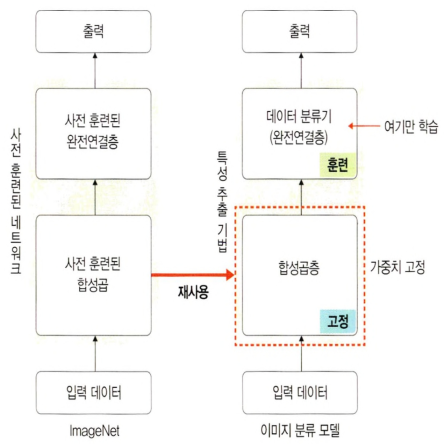

In [2]:
import os 
import cv2
import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import warnings 
warnings.filterwarnings('ignore')

In [3]:
train_path = r'.\cat_dog_classification\catanddog\train'

transform = transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                ])


train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, num_workers=4, shuffle=True)


print(train_dataloader.dataset)

Dataset ImageFolder
    Number of datapoints: 385
    Root location: .\cat_dog_classification\catanddog\train
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# pretrained model load
model = models.resnet18(pretrained = True)

# 사전 학습 모델 가중치 사용 False
for param in model.parameters():
    param.requires_grad = False                # 모델의 fc층만 사용할것이기 때문에 나머지 Layer 가중치 업데이트 안함
    
# fc층 설정 2 => classes 2개 
model.fc = nn.Linear(512, 2)

In [ ]:


optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
epochs = 50


# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델을 GPU로 이동

acc_his = []
loss_his = []
for epoch in range(epochs):
    
    # loss
    train_loss = 0.0
    
    # best_accuracy
    best_accuracy = 0.0
    
    # 올바르게 예측한 수 
    correct = 0
    
    # 전체 수 len()
    # total = 0
    
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outs = model(X)
        loss = criterion(outs, y)
        loss.backward()
        optimizer.step()
        
        # 정확도 계산
        train_loss = loss.item() * X.size(0)    # X.size(0) => 배치수
        
        # outs(결과)의 최대값과 그 인덱스 출력
        max_value, pred = outs.max(1)
        
        # 데이터의 총 개수 
        # total += y.size(0)
        
        # 모델이 올바르게 예측한 샘플 수를 누적  eq = equals
        correct += sum(pred == y)   
        # correct += pred.eq(y).sum().item()   
        # correct += (pred == y).sum().item()
        
    # 데이터셋의 loss, accuracy   
    epoch_loss = train_loss / len(train_dataset)
    accuracy = correct / len(train_dataset)
    # epoch_loss = train_loss / total
    # accuracy = correct / total
    
    # 현재 정확도가 최고 정확도를 넘으면 최고 정확도 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
    acc_his.append(accuracy)
    loss_his.append(epoch_loss)
        
    
    if (epoch + 1) % 10 == 0:
        print(f'epochs : {epoch+1}/{epochs}, train_loss : {epoch_loss:.4f}, Accuracy : {accuracy:.4f}')
    # print(f'epochs : {epoch+1}/{epochs}, train_loss : {epoch_loss:.4f}, Accuracy : {accuracy:.4f}')
    
    
print(f'best_accuracy : {best_accuracy}')

epochs : 10/50, train_loss : 0.0022, Accuracy : 0.6052
epochs : 20/50, train_loss : 0.0002, Accuracy : 0.7922
epochs : 30/50, train_loss : 0.0047, Accuracy : 0.8208
epochs : 40/50, train_loss : 0.0000, Accuracy : 0.9558
epochs : 50/50, train_loss : 0.0019, Accuracy : 0.5844
best_accuracy : 0.5844155844155844


### **모델 평가**

In [30]:
test_path = r'.\cat_dog_classification\catanddog\test'

transform = transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                ])


test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, num_workers=4, shuffle=True)


print(test_dataloader.dataset)

Dataset ImageFolder
    Number of datapoints: 98
    Root location: .\cat_dog_classification\catanddog\test
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
model.eval()
model.to(device)

test_loss = 0.0
best_accuracy = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        
        outs = model(X)
        loss = criterion(outs, y)
        
        test_loss += loss.item() * X.size(0)
        max_value, pred = outs.max(1)
        # max_value, pred = torch.max(outs, 1)
        
        total += y.size(0)
        correct += pred.eq(y).sum().item()
        # correct += sum(pred == y)
        
    avg_loss = test_loss / total
    accuracy = correct / total

    if accuracy > best_accuracy:
        best_accuracy = avg_loss
        
print(f"Evaluation Loss: {avg_loss:.4f}, Accuracy: {best_accuracy:.4f}")

Evaluation Loss: 0.6326, Accuracy: 0.63


### **미세 조정(Fine Tuning)**

- 사전 학습된 모델의 가중치를 초기화로 사용하고, 네트워크의 일부(또는 전체)를 새로운 데이터에 맞게 다시 학습합니다.
- 미세 조정의 특징:

1. 특정 작업에 최적화된 특징을 학습할 수 있음.
2. 데이터가 충분하고 새로운 작업이 기존 작업과 다를 때 효과적.
3. 일반적으로 출력층과 상위 계층(layer)들을 재학습.

- 기존의 특성은 그대로 두고 새로운 클래스를 추가한다 => 특성추출  ex) 사자, 호랑이, 표범 분류 모델에서 치타 라벨을 추가한다 
- 기존의 특성을 업데이트 한다 => 파인튜닝  ex) 사자, 호랑이, 표범 분류 모델에서 새로운 호랑이의 특성을 추가한다

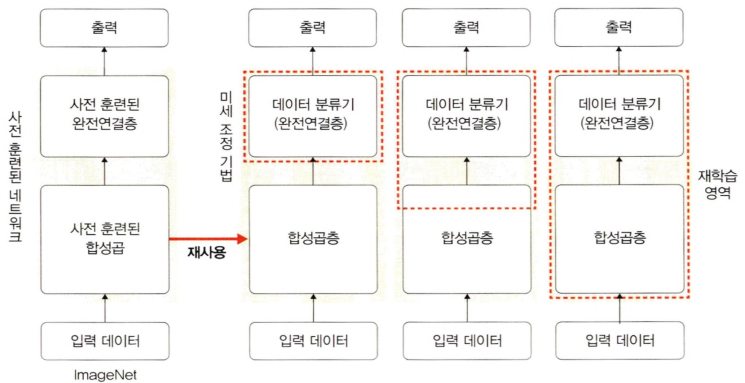